In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlab Plot Settings

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Index Data

In [3]:
# Helper Function
def download_data(ticker, start, end):
    return yf.download(ticker, start, end)

# Start and End Dates for Ticker Data
start_date = "2018-01-01"
end_date = "2020-12-30"
# List of Indices to Retrieve Data
indices = ["^VIX", "^GSPC", "^DJI"]
# List of lists
indices_data = [download_data(index, start_date, end_date) for index in indices]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Percent Movement Per Index
Calculate the % change for each day

In [4]:
# Percent Movement Helper Function
def market_movement(row):
    return (row['Close'] - row['Open'])/row['Open']

# Apply helper function to all index dataframes
percent_movement = [index.apply(market_movement, axis=1) for index in indices_data]

## Visualize Percent Market Per Day

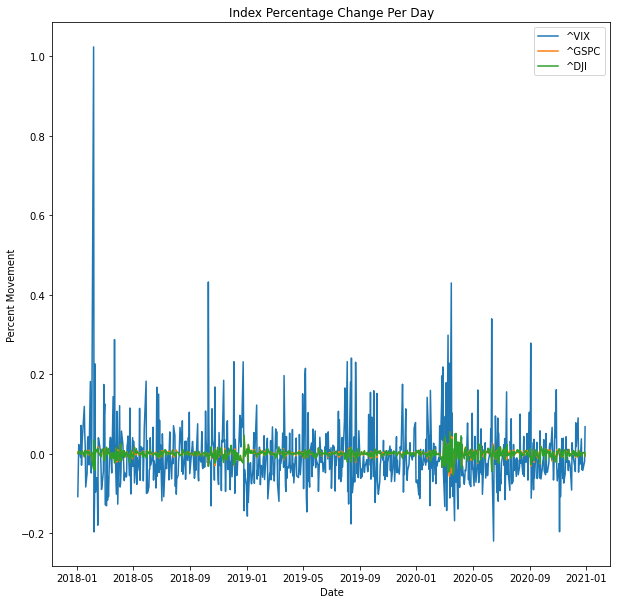

In [5]:
for x in range(len(indices)):
    plt.plot(percent_movement[x], label=indices[x])
plt.xlabel('Date')
plt.ylabel('Percent Movement')
plt.title('Index Percentage Change Per Day')
plt.legend()
plt.show()

## Create Daily Dataframe for Correlation Calculations

In [6]:
# Inital Correlation Dataframe
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
original_columns = all_indices_df.columns
all_indices_df['Day'] = all_indices_df.index

# Add Timeshifts (by Day)
max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

# Direction Change
all_indices_df['GSPC Same Direction'] = (all_indices_df['GSPC Percent Movement'].shift(1) > 0)^(all_indices_df['GSPC Percent Movement'] < 0)
all_indices_df['VIX Same Direction'] = (all_indices_df['VIX Percent Movement'].shift(1) > 0)^(all_indices_df['VIX Percent Movement'] < 0)
        
# Directional Streak ID
all_indices_df['GSPC Streak'] = 0
all_indices_df['VIX Streak'] = 0

all_indices_df['GSPC Streak'] = all_indices_df.apply(lambda x: 1 if not(x['GSPC Same Direction']) else x['GSPC Streak'], axis=1).cumsum()
all_indices_df['VIX Streak'] = all_indices_df.apply(lambda x: 1 if not(x['VIX Same Direction']) else x['VIX Streak'], axis=1).cumsum()

# Count the consecutive days of a particular streak
all_indices_df['GSPC Streak Consecutive Days'] = all_indices_df.groupby("GSPC Streak")['Day'].rank("dense", ascending=True)
all_indices_df['VIX Streak Consecutive Days'] = all_indices_df.groupby("VIX Streak")['Day'].rank("dense", ascending=True)

# Dependent Variable
all_indices_df['VIX Same Direction Next Day'] = all_indices_df['VIX Same Direction'].shift(-1)

# Correlations on Columns
all_indices_df.tail(10)

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,Day,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,DJI Percent Movement + 1 Day Shift,VIX Percent Movement + 2 Day Shift,GSPC Percent Movement + 2 Day Shift,DJI Percent Movement + 2 Day Shift,VIX Percent Movement + 3 Day Shift,GSPC Percent Movement + 3 Day Shift,DJI Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days,VIX Same Direction Next Day
Date,,,,,,,,,,,,,,,,,,,,
2020-12-15,-0.046250,0.007694,0.009366,2020-12-15,-0.000444,0.001331,-0.001220,-0.002275,0.002378,0.002891,-0.026185,-0.003487,-0.004460,False,False,377,363,1.0,1.0,True
2020-12-16,-0.000444,0.001331,-0.001220,2020-12-16,-0.002275,0.002378,0.002891,-0.026185,-0.003487,-0.004460,0.037526,0.002888,0.001905,True,True,377,363,2.0,2.0,True
2020-12-17,-0.002275,0.002378,0.002891,2020-12-17,-0.026185,-0.003487,-0.004460,0.037526,0.002888,0.001905,-0.040016,-0.002926,-0.006116,True,True,377,363,3.0,3.0,True
2020-12-18,-0.026185,-0.003487,-0.004460,2020-12-18,0.037526,0.002888,0.001905,-0.040016,-0.002926,-0.006116,-0.007663,-0.000923,0.002766,False,True,378,363,1.0,4.0,False
2020-12-21,0.037526,0.002888,0.001905,2020-12-21,-0.040016,-0.002926,-0.006116,-0.007663,-0.000923,0.002766,-0.041833,0.002444,0.001457,False,False,379,364,1.0,1.0,False
2020-12-22,-0.040016,-0.002926,-0.006116,2020-12-22,-0.007663,-0.000923,0.002766,-0.041833,0.002444,0.001457,-0.018544,0.003312,0.003987,False,False,380,365,1.0,1.0,True
2020-12-23,-0.007663,-0.000923,0.002766,2020-12-23,-0.041833,0.002444,0.001457,-0.018544,0.003312,0.003987,0.068024,-0.006125,-0.005129,True,True,380,365,2.0,2.0,True
2020-12-24,-0.041833,0.002444,0.001457,2020-12-24,-0.018544,0.003312,0.003987,0.068024,-0.006125,-0.005129,NaN,NaN,NaN,False,True,381,365,1.0,3.0,True
2020-12-28,-0.018544,0.003312,0.003987,2020-12-28,0.068024,-0.006125,-0.005129,NaN,NaN,NaN,NaN,NaN,NaN,True,True,381,365,2.0,4.0,False


## VIX Directional Model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Categorical Label Encoder for Dependent Variable
le = preprocessing.LabelEncoder()

#X = all_indices_df[['GSPC Streak Consecutive Days', 'VIX Streak Consecutive Days', 'VIX Percent Movement', 'GSPC Percent Movement', 'DJI Percent Movement']][:-1]
X = all_indices_df[['VIX Percent Movement']][:-1]
y = all_indices_df['VIX Same Direction Next Day'][:-1]

# Encode Categorical Dependent Variable
le.fit(y)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Train the Model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Prediction
clf.predict(X_test)
clf.predict_proba(X_test)

# Score the Model
clf.score(X_test, y_test)

0.6026490066225165

## Calculate Correlations

In [8]:
# Correlations on Columns
all_indices_df.corr(method ='pearson')

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,DJI Percent Movement + 1 Day Shift,VIX Percent Movement + 2 Day Shift,GSPC Percent Movement + 2 Day Shift,DJI Percent Movement + 2 Day Shift,VIX Percent Movement + 3 Day Shift,GSPC Percent Movement + 3 Day Shift,DJI Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days
VIX Percent Movement,1.000000,-0.661675,-0.633838,-0.034724,0.130759,0.118338,0.020613,-0.063936,-0.072941,0.026486,-0.097178,-0.077030,0.028109,-0.072972,-0.046430,-0.046208,0.030428,-0.091632
GSPC Percent Movement,-0.661675,1.000000,0.959843,0.119063,-0.202923,-0.197977,-0.045074,0.078493,0.087655,0.004047,-0.006938,-0.039951,-0.021802,0.003987,0.013463,0.013347,-0.009179,0.031646
DJI Percent Movement,-0.633838,0.959843,1.000000,0.109494,-0.181525,-0.186190,-0.036583,0.073864,0.081599,0.001568,-0.000041,-0.038742,-0.009890,-0.000798,0.007962,0.008067,0.000772,0.033242
VIX Percent Movement + 1 Day Shift,-0.034724,0.119063,0.109494,1.000000,-0.661720,-0.634387,-0.035524,0.131797,0.118900,0.021153,-0.063736,-0.072357,-0.038616,0.011057,-0.049164,-0.049491,0.030704,-0.003443
GSPC Percent Movement + 1 Day Shift,0.130759,-0.202923,-0.181525,-0.661720,1.000000,0.959931,0.119359,-0.203293,-0.198163,-0.045263,0.078411,0.087444,0.062953,0.027060,0.014340,0.014371,0.030735,0.050530
DJI Percent Movement + 1 Day Shift,0.118338,-0.197977,-0.186190,-0.634387,0.959931,1.000000,0.109544,-0.181600,-0.186218,-0.036608,0.073853,0.081579,0.044597,0.019804,0.008055,0.008204,0.025359,0.050006
VIX Percent Movement + 2 Day Shift,0.020613,-0.045074,-0.036583,-0.035524,0.119359,0.109544,1.000000,-0.661609,-0.634343,-0.035337,0.131918,0.119181,0.043898,-0.012334,-0.050487,-0.050604,0.052641,-0.018473
GSPC Percent Movement + 2 Day Shift,-0.063936,0.078493,0.073864,0.131797,-0.203293,-0.181600,-0.661609,1.000000,0.959970,0.119164,-0.203452,-0.198514,-0.045410,0.016671,0.015854,0.015758,0.008951,0.049432
DJI Percent Movement + 2 Day Shift,-0.072941,0.087655,0.081599,0.118900,-0.198163,-0.186218,-0.634343,0.959970,1.000000,0.109444,-0.181669,-0.186392,-0.030196,0.012894,0.008870,0.008924,0.019992,0.044654
VIX Percent Movement + 3 Day Shift,0.026486,0.004047,0.001568,0.021153,-0.045263,-0.036608,-0.035337,0.119164,0.109444,1.000000,-0.661733,-0.634626,0.044554,-0.000877,-0.049705,-0.050040,0.076690,0.017752


## Monthly Correlations

In [9]:
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
all_indices_df['Month'] = all_indices_df.index.year * 100 + all_indices_df.index.month

months = all_indices_df['Month'].unique().tolist()

max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

all_indices_df = all_indices_df.groupby(['Month']).corr(method ='pearson')

vix = []
dji = []
vix_1 = []
dji_1 = []
vix_2 = []
dji_2 = []
vix_3 = []
dji_3 = []

for month in months:
    monthly_indices_df = all_indices_df.loc[month, "GSPC Percent Movement"]
    vix.append(monthly_indices_df['VIX Percent Movement'])
    dji.append(monthly_indices_df['DJI Percent Movement'])
    vix_1.append(monthly_indices_df['VIX Percent Movement + 1 Day Shift'])
    dji_1.append(monthly_indices_df['DJI Percent Movement + 1 Day Shift'])
    vix_2.append(monthly_indices_df['VIX Percent Movement + 2 Day Shift'])
    dji_2.append(monthly_indices_df['DJI Percent Movement + 2 Day Shift'])
    vix_3.append(monthly_indices_df['VIX Percent Movement + 3 Day Shift'])
    dji_3.append(monthly_indices_df['DJI Percent Movement + 3 Day Shift'])
    
monthly_data = {'MONTH': [datetime.strptime(str(month), '%Y%m') for month in months], 'VIX': vix, 'DOW': dji, 'VIX+1': vix_1, 'DJI+1': dji_1, 'VIX+2': vix_2, 'DJI+2': dji_2, 'VIX+3': vix_3, 'DJI+3': dji_3}
monthly_df = pd.DataFrame(data = monthly_data).set_index('MONTH')
#monthly_df.to_csv('sp500_correlation_raw.csv')
monthly_df


,VIX,DOW,VIX+1,DJI+1,VIX+2,DJI+2,VIX+3,DJI+3
MONTH,,,,,,,,
2018-01-01,-0.565359,0.860012,0.317682,-0.293251,-0.054204,0.226206,-0.325202,0.316712
2018-02-01,-0.757415,0.987170,-0.138880,-0.005986,0.288273,-0.466581,-0.060092,0.172896
2018-03-01,-0.859288,0.961689,0.177361,-0.155674,0.067747,-0.077555,-0.530501,0.374212
2018-04-01,-0.800092,0.976117,-0.049803,0.060709,0.271888,-0.453093,0.237156,-0.262256
2018-05-01,-0.698296,0.889919,0.067769,-0.195455,0.148382,-0.043065,0.084612,0.084648
2018-06-01,-0.814000,0.848683,0.145764,-0.172423,-0.384982,0.430915,0.368345,-0.277038
2018-07-01,-0.765313,0.798135,0.114160,0.129619,0.533952,-0.004068,-0.018604,-0.238733
2018-08-01,-0.773935,0.776297,0.202197,-0.014369,-0.265836,0.147262,0.090121,-0.234086
2018-09-01,-0.685961,0.738873,-0.090018,0.076854,0.229176,0.112778,0.080186,-0.212138


## Plot Monthly Correlations over Time for SP500

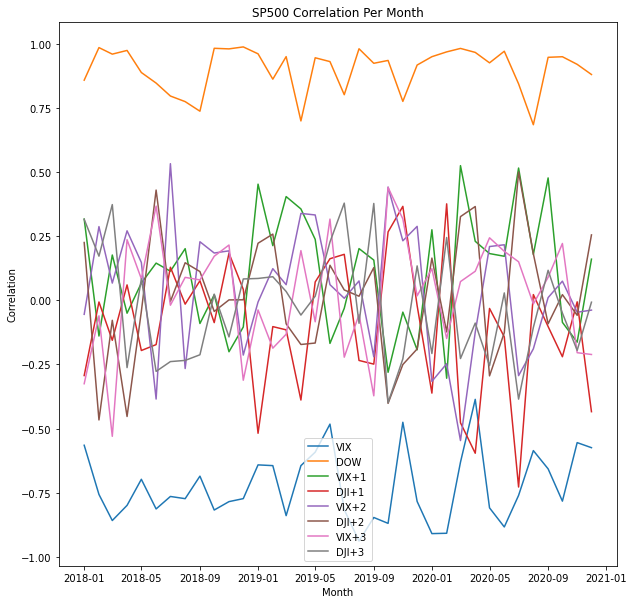

In [10]:
for x in range(len(monthly_df.columns)):
    plt.plot(monthly_df[monthly_df.columns[x]], label=monthly_df.columns[x])
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.title('SP500 Correlation Per Month')
plt.legend()
plt.show()